# Features expansion

In [1]:
import pandas as pd
import numpy as np
from scipy.ndimage import convolve

# Exemple de DataFrame
size = 10  # Taille de la grille
data = {
    "x": np.repeat(range(size), size * size),
    "y": np.tile(np.repeat(range(size), size), size),
    "z": np.tile(range(size), size * size),
    "power": np.random.rand(size**3),
    "temperature": np.random.rand(size**3),
}
df = pd.DataFrame(data)

# Créer une grille 3D pour la colonne 'power'
power_grid = np.zeros((size, size, size))
for _, row in df.iterrows():
    power_grid[int(row["x"]), int(row["y"]), int(row["z"])] = row["power"]

# Définir un filtre 3x3x3 (moyenne des voisins)
kernel = np.ones((3, 3, 3)) / 27  # Poids uniformes pour tous les voisins

# Appliquer la convolution
filtered_power_grid = convolve(power_grid, kernel, mode="constant", cval=0)

# Ajouter les valeurs filtrées dans le DataFrame
df["filtered_power"] = [
    filtered_power_grid[int(row["x"]), int(row["y"]), int(row["z"])]
    for _, row in df.iterrows()
]

# Afficher un aperçu du DataFrame
display(df.head())

,x,y,z,power,temperature,filtered_power
0,0,0,0,0.493908,0.906932,0.159405
1,0,0,1,0.369818,0.761165,0.240349
2,0,0,2,0.261296,0.066039,0.221281
3,0,0,3,0.156298,0.753786,0.251167
4,0,0,4,0.244380,0.371325,0.274535


# simulation_results.csv digging

In [2]:
df = pd.read_csv("simulation_results.csv")

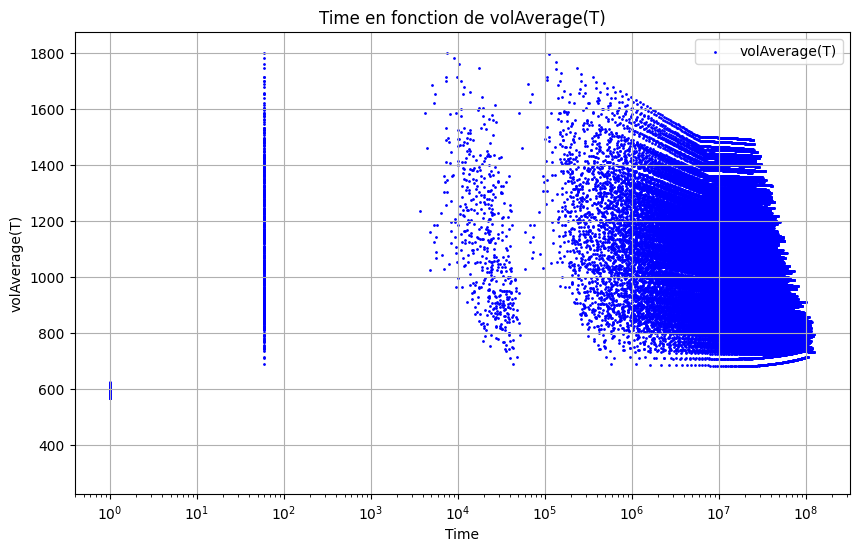

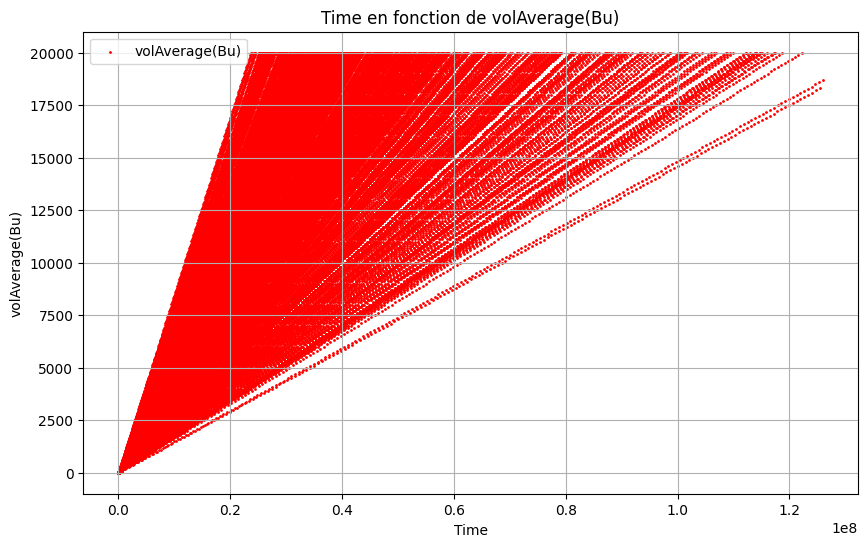

In [3]:
import matplotlib.pyplot as plt

# Graphique scatter en fonction de volAverage(T)
plt.figure(figsize=(10, 6))
plt.scatter(
    df["time"], df["volAverage(T)"], color="blue", label="volAverage(T)", s=1
)  # s=10 réduit la taille des points
plt.title("Time en fonction de volAverage(T)")
plt.xlabel("Time")
plt.xscale("log")
plt.ylabel("volAverage(T)")
plt.grid(True)
plt.legend()
plt.show()

# Graphique scatter en fonction de volAverage(Bu)
plt.figure(figsize=(10, 6))
plt.scatter(df["time"], df["volAverage(Bu)"], color="red", label="volAverage(Bu)", s=1)
plt.title("Time en fonction de volAverage(Bu)")
plt.xlabel("Time")
plt.ylabel("volAverage(Bu)")
plt.grid(True)
plt.legend()
plt.show()

# ML linear

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score,
)
from sklearn.metrics import root_mean_squared_error


def linear_regression(df):
    # Définir les entrées (features) et la sortie (target)
    X = df[
        [
            "lhgr",
            "fuel_radius",
            "gap_size",
            "clad_thickness",
            "coolant_temperature",
            "time",
        ]
    ]
    y = df["volAverage(T)"]

    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Standardiser les données pour mieux interpréter les coefficients
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Entraîner le modèle de régression linéaire
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)  # Étape essentielle pour ajuster le modèle

    # Prédictions
    y_pred = model.predict(X_test_scaled)

    # Calcul des métriques
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = 100 * (np.abs((y_test - y_pred) / y_test)).mean()

    # Affichage des métriques
    print(f"Régression Linéaire - Évaluation des métriques :")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"MedAE : {medae:.4f}")
    print(f"R² : {r2:.4f}")
    print(f"MAPE : {mape:.2f}%")

    # Obtenir les poids (coefficients)
    coefficients = model.coef_
    features = X.columns

    # Affichage des résultats
    print("\nCoefficients trouvés par le modèle :")
    for feature, coef in zip(features, coefficients):
        print(f"{feature}: {coef:.4f}")

In [5]:
linear_regression(df)

Régression Linéaire - Évaluation des métriques :
MSE : 4960.2915
RMSE : 70.4293
MAE : 30.3417
MedAE : 17.9837
R² : 0.8596
MAPE : 3.83%

Coefficients trouvés par le modèle :
lhgr: 154.9319
fuel_radius: -17.2907
gap_size: 88.2378
clad_thickness: 7.1745
coolant_temperature: 10.7770
time: 2.0909


# Neural network

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score,
)
from sklearn.metrics import root_mean_squared_error
from tqdm import tqdm

In [7]:
def fully_connected_NN(K, L, num_epochs):
    # Définir les entrées (features) et la sortie (target)
    X = df[
        [
            "lhgr",
            "fuel_radius",
            "gap_size",
            "clad_thickness",
            "coolant_temperature",
            "time",
        ]
    ].values
    y = df["volAverage(T)"].values

    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Standardiser les données
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convertir les données en tenseurs PyTorch
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Définir le modèle
    class NeuralNetwork(nn.Module):
        def __init__(self, input_size, hidden_size, num_hidden_layers):
            super(NeuralNetwork, self).__init__()
            layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
            for _ in range(num_hidden_layers - 1):
                layers.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
            layers.append(nn.Linear(hidden_size, 1))
            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    # Initialisation du modèle
    model = NeuralNetwork(
        input_size=X_train_tensor.shape[1], hidden_size=K, num_hidden_layers=L
    )

    # Définir la fonction de perte et l'optimiseur
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entraîner le modèle
    train_losses = []
    test_losses = []

    # for epoch in tqdm(range(num_epochs), desc="nombre epochs"):
    for epoch in range(num_epochs):
        # Entraînement
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

        # Évaluation sur l'ensemble de test
        model.eval()
        with torch.no_grad():
            test_predictions = model(X_test_tensor)
            test_loss = criterion(test_predictions, y_test_tensor)

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        print(
            f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}"
        )

    # Visualisation des courbes de perte
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    plt.title("Loss curve")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Visualisation des prédictions
    with torch.no_grad():
        y_pred = model(X_test_tensor).numpy()

    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, edgecolors="k", label="Prédictions vs Réel")
    plt.plot(
        [min(y_test), max(y_test)],
        [min(y_test), max(y_test)],
        color="red",
        linestyle="--",
        label="Idéal",
    )
    plt.title("Prédictions vs Réel")
    plt.xlabel("Valeurs réelles de volAverage(T)")
    plt.ylabel("Valeurs prédites")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Évaluation des prédictions sur l'ensemble de test
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        y_pred = y_pred_tensor.numpy().flatten()

    # Calcul des métriques
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = 100 * (np.abs((y_test - y_pred) / y_test)).mean()

    # Affichage des métriques
    print(f"Réseau de Neurones - Évaluation des métriques :")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"MedAE : {medae:.4f}")
    print(f"R² : {r2:.4f}")
    print(f"MAPE : {mape:.2f}%")

    return model, y_test, y_pred, train_losses, test_loss, mse, rmse, mae, medae, r2, mape

In [8]:
# tenter NN avec dropout si le réseau overfit
# ajouter des checkpoints : enregistre les poids tous les n epochs
# borner la sortie
# borner la loss (clipping)

Epoch 1/3000, Loss: 1117283.7500, Test Loss: 1118660.5000
Epoch 2/3000, Loss: 1117268.6250, Test Loss: 1118645.2500
Epoch 3/3000, Loss: 1117253.5000, Test Loss: 1118630.3750
Epoch 4/3000, Loss: 1117238.3750, Test Loss: 1118615.6250
Epoch 5/3000, Loss: 1117223.6250, Test Loss: 1118600.6250
Epoch 6/3000, Loss: 1117208.7500, Test Loss: 1118586.7500
Epoch 7/3000, Loss: 1117194.8750, Test Loss: 1118573.1250
Epoch 8/3000, Loss: 1117181.3750, Test Loss: 1118559.1250
Epoch 9/3000, Loss: 1117167.3750, Test Loss: 1118545.2500
Epoch 10/3000, Loss: 1117153.5000, Test Loss: 1118531.1250
Epoch 11/3000, Loss: 1117139.3750, Test Loss: 1118517.0000
Epoch 12/3000, Loss: 1117125.1250, Test Loss: 1118502.6250
Epoch 13/3000, Loss: 1117110.8750, Test Loss: 1118488.1250
Epoch 14/3000, Loss: 1117096.3750, Test Loss: 1118473.5000
Epoch 15/3000, Loss: 1117081.7500, Test Loss: 1118458.6250
Epoch 16/3000, Loss: 1117067.1250, Test Loss: 1118443.8750
Epoch 17/3000, Loss: 1117052.2500, Test Loss: 1118428.8750
Epoch 

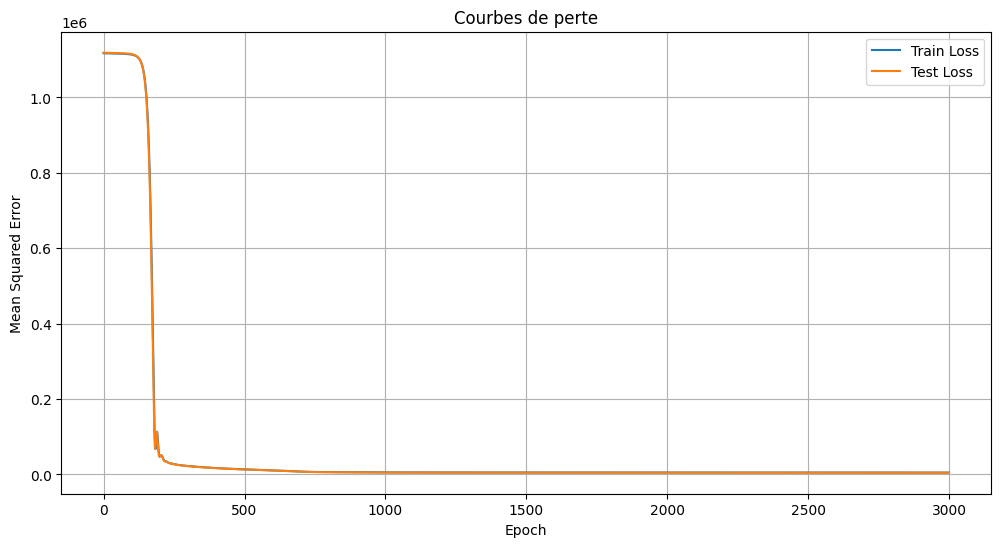

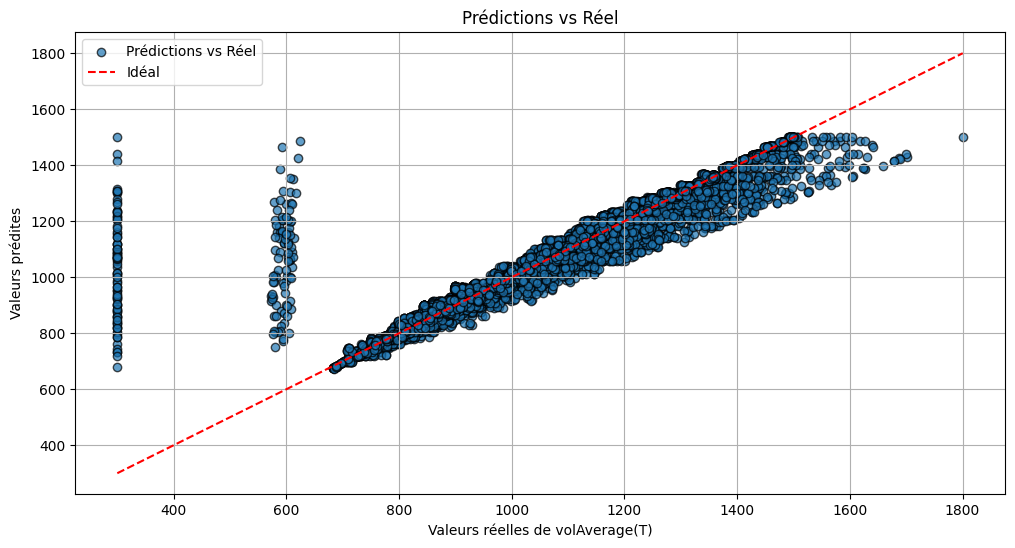

Réseau de Neurones - Évaluation des métriques :
MSE : 4544.5320
RMSE : 67.4131
MAE : 24.6299
MedAE : 13.3606
R² : 0.8713
MAPE : 3.23%


In [9]:
K = 10
L = 10
num_epochs = 3000

model, y_test, y_pred, train_losses, test_loss, mse, rmse, mae, medae, r2, mape = fully_connected_NN(K, L, num_epochs)